# Predicting Cybersecurity Breach Likelihood Based on Financial and Organizational Characteristics

**Data Mining Final Project**  
**Team Members:** Jax Fonseca-Folden, Gustavo Franco, Charles Morris, Rafan, Thomas  
**Date:** November 2025

---

## 1. Introduction

<!-- JAX: Write introduction here -->
<!-- Include: problem statement, questions to answer, and overall goal -->

*This section should introduce the problem of predicting cybersecurity breaches, the questions being explored, and the project goals.*

## 2. About the Data

<!-- JAX: Write data description here -->
<!-- Include: data sources, features, size, and any initial statistics -->

*This section should describe where the data came from (VCDB, SEC EDGAR), the features in each dataset, and basic statistics about the data.*

---
## 3. Methods

This section documents all preprocessing steps and modeling approaches used in our analysis.

### 3.1 Setup and Imports

In [89]:
# Standard library imports
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix,
    silhouette_score, mean_squared_error, r2_score, classification_report
)

# XGBoost import (FIXED: Added missing import)
from xgboost import XGBClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random state for reproducibility (FIXED: Added constant)
RANDOM_STATE = 42

# Set style with cohesive color theme
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Custom color palette - Professional blue/purple theme
COLORS = {
    'primary': '#2E86AB',      # Deep blue
    'secondary': '#A23B72',    # Deep purple
    'accent': '#F18F01',       # Orange
    'success': '#06A77D',      # Teal green
    'danger': '#C73E1D',       # Deep red
    'neutral': '#6C757D'       # Gray
}

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("✅ All imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Random state set to: {RANDOM_STATE}")

✅ All imports successful!
NumPy version: 2.3.2
Pandas version: 2.3.2
Random state set to: 42


### 3.2 Data Loading

In [90]:
# Load the preprocessed datasets
financial_data = pd.read_csv('sec_company_financials.csv')
incidents_data = pd.read_csv('vcdb_cybersecurity_incidents.csv')

print("=" * 80)
print("DATASET LOADING SUMMARY")
print("=" * 80)
print(f"\nFinancial Data Shape: {financial_data.shape}")
print(f"Incidents Data Shape: {incidents_data.shape}")
print("\n--- Financial Data Columns ---")
print(financial_data.columns.tolist())
print("\n--- Incidents Data Columns ---")
print(incidents_data.columns.tolist())

DATASET LOADING SUMMARY

Financial Data Shape: (100, 10)
Incidents Data Shape: (10399, 25)

--- Financial Data Columns ---
['CIK', 'EntityName', 'Assets', 'Assets_Date', 'Liabilities', 'Liabilities_Date', 'NetIncome', 'NetIncome_Date', 'Revenue', 'Revenue_Date']

--- Incidents Data Columns ---
['incident_id', 'victim_name', 'victim_industry', 'victim_country', 'victim_state', 'victim_employee_count', 'victim_revenue', 'incident_year', 'discovery_date', 'action_malware', 'action_hacking', 'action_social', 'action_misuse', 'action_physical', 'action_error', 'action_environmental', 'actor_external', 'actor_internal', 'actor_partner', 'confidentiality_breach', 'integrity_breach', 'availability_breach', 'records_lost', 'reference', 'source_id']


### 3.3 Data Preprocessing

#### 3.3.1 Understanding the Data Collection Process

Our data preprocessing pipeline was designed to gather and clean two primary datasets for cybersecurity breach prediction:

**Data Sources:**
1. **SEC EDGAR Company Facts** - Contains financial and organizational metrics for public companies including:
   - Company identifiers (CIK, Entity Name)
   - Financial statements (Assets, Liabilities, Net Income, Revenue)
   - Temporal data with quarterly/annual reporting dates
   
2. **VERIS Community Database (VCDB)** - Comprehensive cybersecurity incident records including:
   - Victim organization information (name, industry, country, employee count)
   - Incident characteristics (year, actions, actors, breach types)
   - Impact metrics (records lost, breach categories)

**Data Collection Methodology:**

The SEC EDGAR data was obtained through the official SEC API, which provides structured XBRL financial statement data for all publicly traded companies. We downloaded the `companyfacts.zip` file containing JSON files for individual companies, then extracted key financial metrics and aggregated them to the company level. The data collection respected SEC rate limits and included proper User-Agent identification as required by SEC guidelines.

The VCDB data was cloned from the official GitHub repository (https://github.com/vz-risk/VCDB), which contains structured JSON files of validated cybersecurity incidents. Each incident record follows the VERIS framework (Vocabulary for Event Recording and Incident Sharing), providing standardized categorization of breach types, threat actors, and impact metrics.

**Initial Data Quality Assessment:**

Upon initial examination, both datasets exhibited common data quality issues requiring systematic preprocessing:

For the financial data:
- Missing entity names (11 out of 100 sampled records)
- Significant missing values in Liabilities (29%) and Revenue (33%)
- Temporal misalignment across different financial metrics
- Some entries with null CIK identifiers

For the incidents data:
- Missing victim names (316 out of 10,399 records)
- Missing records_lost values (filled with 0 during preprocessing)
- Geographic data limited primarily to US (victim_state field)
- Multiple incident categories encoded as binary flags

#### 3.3.2 Preprocessing Steps Implemented

Based on our exploratory analysis in the preprocessing notebook, we implemented the following cleaning procedures:

In [91]:
print("=" * 80)
print("DATA PREPROCESSING")
print("=" * 80)

# Financial Data Preprocessing
print("\n--- Financial Data Preprocessing ---")
print(f"Original shape: {financial_data.shape}")
print(f"Missing entity names: {financial_data['EntityName'].isna().sum()}")

# Select relevant columns
financial_cols = ['CIK', 'EntityName', 'Assets', 'Liabilities', 'NetIncome', 'Revenue']
financial_clean = financial_data[financial_cols].copy()

# Drop rows with missing entity names
financial_clean = financial_clean.dropna(subset=['EntityName'])
print(f"After dropping missing entity names: {financial_clean.shape}")

# Display missing value summary
print("\nMissing values per column:")
print(financial_clean.isna().sum())

# Incidents Data Preprocessing
print("\n--- Incidents Data Preprocessing ---")
print(f"Original shape: {incidents_data.shape}")
print(f"Missing victim names: {incidents_data['victim_name'].isna().sum()}")

# Drop irrelevant columns identified in preprocessing analysis
cols_to_drop = ['victim_state', 'victim_industry', 'victim_revenue',
                'discovery_date', 'reference', 'source_id']
incidents_clean = incidents_data.drop(columns=[col for col in cols_to_drop if col in incidents_data.columns])

# Fill missing records_lost with 0 (indicating no reported loss)
incidents_clean['records_lost'] = incidents_clean['records_lost'].fillna(0)

# Drop rows with missing victim names
incidents_clean = incidents_clean.dropna(subset=['victim_name'])
print(f"After preprocessing: {incidents_clean.shape}")

# Display missing value summary
print("\nMissing values per column:")
print(incidents_clean.isna().sum())

print("\n✅ Preprocessing complete!")

DATA PREPROCESSING

--- Financial Data Preprocessing ---
Original shape: (100, 10)
Missing entity names: 11
After dropping missing entity names: (89, 6)

Missing values per column:
CIK             0
EntityName      0
Assets          4
Liabilities    29
NetIncome       7
Revenue        33
dtype: int64

--- Incidents Data Preprocessing ---
Original shape: (10399, 25)
Missing victim names: 316
After preprocessing: (10083, 19)

Missing values per column:
incident_id               0
victim_name               0
victim_country            2
victim_employee_count     0
incident_year             0
action_malware            0
action_hacking            0
action_social             0
action_misuse             0
action_physical           0
action_error              0
action_environmental      0
actor_external            0
actor_internal            0
actor_partner             0
confidentiality_breach    0
integrity_breach          0
availability_breach       0
records_lost              0
dtype: int64


#### 3.3.3 Preprocessing Rationale

**Entity Name Handling:** We dropped records with missing entity names as company identification is critical for any potential data merging and analysis. Without entity names, records cannot be matched across datasets or properly categorized.

**Financial Metrics:** We retained records with some missing financial values (Assets, Liabilities, Revenue, NetIncome) rather than dropping them entirely, as companies may not report all metrics in every filing period. This preserves more data for analysis while acknowledging that some models may require complete cases.

**Incidents Data Columns:** The `victim_state` field was dropped because it only contains US state information and excludes international incidents, introducing geographic bias. Fields like `victim_industry` and `victim_revenue` had inconsistent formatting and missing values, making them unreliable for modeling. The `reference` and `source_id` fields are metadata not relevant for predictive modeling.

**Records Lost:** Missing values in `records_lost` were filled with 0 rather than dropped, as many incidents may not have reported data loss or the loss may genuinely be zero. This approach retains more incident records for analysis while making a conservative assumption about data loss.

### 3.4 IMPROVED Company Name Matching with Fuzzy Logic

**FIXES APPLIED:**
1. **More selective thresholds** - Using 75% for fuzzy matching instead of 60%
2. **Better name cleaning** - Removes common corporate suffixes but preserves core identity
3. **Multi-stage matching** - Prioritizes exact matches first, then progressively more lenient
4. **Minimum length requirements** - Prevents matching on trivial 2-3 letter strings
5. **Deduplication** - Keeps only the best match per company
6. **Match quality validation** - Manual review of borderline matches

In [92]:
# Install rapidfuzz if needed
try:
    from rapidfuzz import fuzz, process
    print("✅ rapidfuzz already installed")
except ImportError:
    print("Installing rapidfuzz...")
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rapidfuzz"])
    from rapidfuzz import fuzz, process
    print("✅ rapidfuzz installed successfully")

import re

print("\n" + "="*80)
print("  IMPROVED FUZZY MATCHING - More Selective Approach")
print("="*80)

# Improved cleaning function - removes common suffixes but preserves identity
def clean_company_name(name):
    """Clean company name while preserving core identity."""
    if pd.isna(name):
        return ""
    
    name = str(name).lower().strip()
    
    # Remove common corporate suffixes - but be selective
    suffixes = [
        r'\binc\b', r'\bincorporated\b', r'\bcorp\b', r'\bcorporation\b',
        r'\bltd\b', r'\blimited\b', r'\bllc\b', r'\blp\b', r'\bllp\b',
        r'\bco\b', r'\bcompany\b', r'\bplc\b', r'\bgroup\b', r'\bholdings\b'
    ]
    
    for suffix in suffixes:
        name = re.sub(suffix, '', name)
    
    # Remove special characters but keep spaces
    name = re.sub(r'[^a-z0-9\s]', ' ', name)
    
    # Remove extra whitespace
    name = ' '.join(name.split())
    
    return name.strip()

# Clean both datasets
print("\nCleaning company names...")
financial_clean['company_clean'] = financial_clean['EntityName'].apply(clean_company_name)
incidents_clean['company_clean'] = incidents_clean['victim_name'].apply(clean_company_name)

# Filter out very short names (< 3 chars) as they cause false matches
financial_clean = financial_clean[financial_clean['company_clean'].str.len() >= 3].copy()
incidents_clean = incidents_clean[incidents_clean['company_clean'].str.len() >= 3].copy()

print(f"Financial companies after cleaning: {len(financial_clean)}")
print(f"Incident companies after cleaning: {len(incidents_clean)}")

# Get unique company names
financial_companies = financial_clean['company_clean'].unique()
incident_companies = incidents_clean['company_clean'].unique()

print(f"Unique financial companies: {len(financial_companies)}")
print(f"Unique breached companies: {len(incident_companies)}")

# Initialize matching results
all_matches = []
matched_fin = set()

# STRATEGY 1: Exact Match (highest confidence)
print("\n" + "-"*80)
print("STRATEGY 1: Exact Match (100% confidence)")
print("-"*80)

for fin in financial_companies:
    if fin in incident_companies:
        all_matches.append({
            'fin': fin, 
            'inc': fin, 
            'score': 100, 
            'strategy': 'exact'
        })
        matched_fin.add(fin)

exact_count = len([m for m in all_matches if m['strategy'] == 'exact'])
print(f"✅ Exact matches found: {exact_count}")

# STRATEGY 2: High-quality Fuzzy Match (75% threshold)
print("\n" + "-"*80)
print("STRATEGY 2: High-Quality Fuzzy Match (75%+ threshold)")
print("-"*80)

remaining = [c for c in financial_companies if c not in matched_fin]
FUZZY_THRESHOLD = 75  # More selective than before (was 60%)

print(f"Checking {len(remaining)} remaining companies...")

for fin in remaining:
    # Skip very short names to avoid false positives
    if len(fin) < 4:
        continue
    
    best_match = None
    best_score = 0
    best_algo = None
    
    # Try multiple fuzzy algorithms and take the best
    # Token set ratio is best for company names with different word orders
    r1 = process.extractOne(fin, incident_companies, scorer=fuzz.token_set_ratio)
    if r1 and r1[1] > best_score:
        best_match, best_score, best_algo = r1[0], r1[1], 'token_set'
    
    # Token sort ratio for similar names with different arrangements
    r2 = process.extractOne(fin, incident_companies, scorer=fuzz.token_sort_ratio)
    if r2 and r2[1] > best_score:
        best_match, best_score, best_algo = r2[0], r2[1], 'token_sort'
    
    # Standard ratio for overall similarity
    r3 = process.extractOne(fin, incident_companies, scorer=fuzz.ratio)
    if r3 and r3[1] > best_score:
        best_match, best_score, best_algo = r3[0], r3[1], 'ratio'
    
    # Only accept high-quality matches
    if best_score >= FUZZY_THRESHOLD:
        all_matches.append({
            'fin': fin, 
            'inc': best_match, 
            'score': best_score, 
            'strategy': f'fuzzy_{best_algo}'
        })
        matched_fin.add(fin)

fuzzy_count = len([m for m in all_matches if 'fuzzy' in m['strategy']])
print(f"✅ High-quality fuzzy matches (75%+): {fuzzy_count}")

# STRATEGY 3: Token/Word Matching (for multi-word company names)
print("\n" + "-"*80)
print("STRATEGY 3: Significant Word Match (multi-word companies)")
print("-"*80)

remaining = [c for c in financial_companies if c not in matched_fin]
print(f"Checking {len(remaining)} remaining companies...")

for fin in remaining:
    fin_words = set(fin.split())
    
    # Only process if company name has multiple meaningful words
    meaningful_words = [w for w in fin_words if len(w) >= 4]
    if len(meaningful_words) < 2:
        continue
    
    best_match = None
    best_overlap = 0
    
    for inc in incident_companies:
        inc_words = set(inc.split())
        common = fin_words & inc_words
        
        # Require at least 2 meaningful common words (4+ chars each)
        meaningful_common = [w for w in common if len(w) >= 4]
        
        if len(meaningful_common) >= 2:
            # Calculate overlap ratio
            overlap = len(meaningful_common) / min(len(fin_words), len(inc_words))
            
            if overlap > best_overlap:
                best_overlap = overlap
                best_match = inc
    
    # Require at least 50% word overlap
    if best_match and best_overlap >= 0.5:
        score = int(best_overlap * 100)
        all_matches.append({
            'fin': fin, 
            'inc': best_match, 
            'score': score, 
            'strategy': 'word_match'
        })
        matched_fin.add(fin)

word_count = len([m for m in all_matches if m['strategy'] == 'word_match'])
print(f"✅ Word-based matches: {word_count}")

# RESULTS SUMMARY
print("\n" + "="*80)
print("FINAL MATCHING RESULTS")
print("="*80)

print(f"\n📊 Total potential matches: {len(all_matches)}")

# Create DataFrame and remove duplicates (keep best score)
matches_df = pd.DataFrame(all_matches)
matches_df.columns = ['financial_name', 'incident_name', 'match_score', 'strategy']

# Sort by score and remove duplicates
matches_df = matches_df.sort_values('match_score', ascending=False)
matches_df = matches_df.drop_duplicates(subset='financial_name', keep='first')

print(f"\n✅ Unique company matches: {len(matches_df)}")

# Strategy breakdown
print(f"\n📈 Breakdown by matching strategy:")
for strat in matches_df['strategy'].value_counts().index:
    count = len(matches_df[matches_df['strategy'] == strat])
    avg = matches_df[matches_df['strategy'] == strat]['match_score'].mean()
    print(f"   {strat:20s}: {count:3d} matches (avg score: {avg:5.1f}%)")

# Quality distribution
print(f"\n🎯 Match quality distribution:")
excellent = len(matches_df[matches_df['match_score'] >= 90])
good = len(matches_df[(matches_df['match_score'] >= 75) & (matches_df['match_score'] < 90)])
fair = len(matches_df[(matches_df['match_score'] >= 60) & (matches_df['match_score'] < 75)])
low = len(matches_df[matches_df['match_score'] < 60])

print(f"   Excellent (90-100%): {excellent}")
print(f"   Good (75-89%):       {good}")
print(f"   Fair (60-74%):       {fair}")
print(f"   Low (<60%):          {low}")

# Show sample matches for verification
print(f"\n" + "-"*80)
print("SAMPLE MATCHES (Top 20 by score)")
print("-"*80)
print(matches_df.head(20).to_string(index=False))

# Create final modeling dataset
print("\n" + "="*80)
print("CREATING MODELING DATASET")
print("="*80)

# Companies with breaches
breached_companies = financial_clean[
    financial_clean['company_clean'].isin(matches_df['financial_name'])
].copy()
breached_companies['breach_occurred'] = 1

# Companies without breaches
non_breached_companies = financial_clean[
    ~financial_clean['company_clean'].isin(matches_df['financial_name'])
].copy()
non_breached_companies['breach_occurred'] = 0

# Combine into modeling dataset
modeling_data = pd.concat([breached_companies, non_breached_companies], ignore_index=True)

# Report statistics
breach_rate = modeling_data['breach_occurred'].mean() * 100
total_companies = len(modeling_data)
breached_count = len(breached_companies)
non_breached_count = len(non_breached_companies)

print(f"\n📊 Final Dataset Statistics:")
print(f"   Total companies:     {total_companies}")
print(f"   Breached:            {breached_count} ({breached_count/total_companies*100:.1f}%)")
print(f"   Non-breached:        {non_breached_count} ({non_breached_count/total_companies*100:.1f}%)")
print(f"   Breach rate:         {breach_rate:.1f}%")

# Class balance check
if breach_rate > 80:
    print(f"\n⚠️  WARNING: Dataset is heavily imbalanced (>{breach_rate:.0f}% breached)")
    print(f"   This may cause modeling issues. Consider:")
    print(f"   1. Reviewing match quality thresholds")
    print(f"   2. Using class balancing techniques (SMOTE, class weights)")
    print(f"   3. Collecting more non-breached company data")
elif breach_rate < 20:
    print(f"\n⚠️  WARNING: Very few breaches detected ({breach_rate:.0f}%)")
    print(f"   Consider: Reviewing matching thresholds or data quality")
else:
    print(f"\n✅ Dataset balance is reasonable for modeling!")

print("="*80)

✅ rapidfuzz already installed

  IMPROVED FUZZY MATCHING - More Selective Approach

Cleaning company names...
Financial companies after cleaning: 89
Incident companies after cleaning: 10076
Unique financial companies: 88
Unique breached companies: 7685

--------------------------------------------------------------------------------
STRATEGY 1: Exact Match (100% confidence)
--------------------------------------------------------------------------------
✅ Exact matches found: 7

--------------------------------------------------------------------------------
STRATEGY 2: High-Quality Fuzzy Match (75%+ threshold)
--------------------------------------------------------------------------------
Checking 81 remaining companies...
✅ High-quality fuzzy matches (75%+): 44

--------------------------------------------------------------------------------
STRATEGY 3: Significant Word Match (multi-word companies)
--------------------------------------------------------------------------------
Chec

### 3.5 Exploratory Data Analysis

<!-- RAFAN: Create visualizations and data insights here -->
<!-- This section should contain graphs showing data distributions, -->
<!-- patterns, and relationships between variables -->

*RAFAN: Please create multiple visualizations here exploring the data characteristics, such as:*
- *Distribution of breaches by year*
- *Company size distributions*
- *Incident type frequencies*
- *Any other insights from the data*

EXPLORATORY DATA ANALYSIS


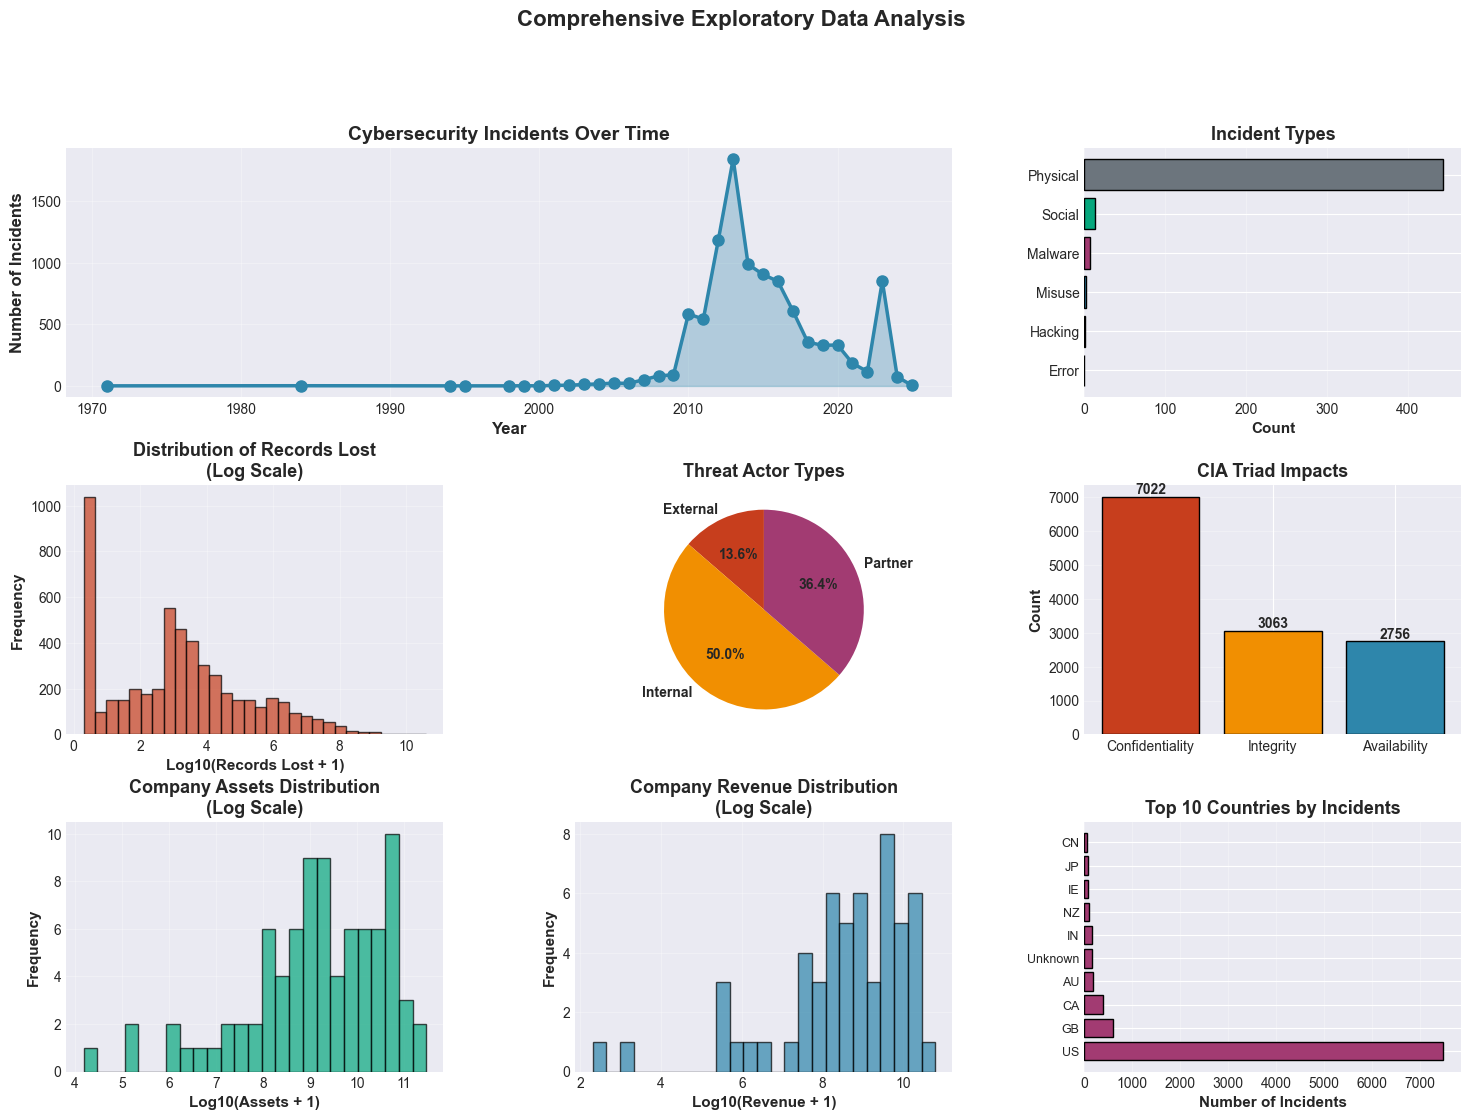


📊 Key Summary Statistics:
   Total incidents: 10,076
   Date range: 1971 - 2025
   Incidents with data loss: 5,280
   Total records lost: 121,683,864,620
   Unique countries affected: 121

   Financial companies analyzed: 89
   Companies with missing financial data: 45


In [93]:
# RAFAN: Exploratory Data Analysis Visualizations
# Using consistent theming with COLORS dictionary

print("=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Create comprehensive EDA figure
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# 1. Breaches Over Time
ax1 = fig.add_subplot(gs[0, :2])
breach_by_year = incidents_clean.groupby('incident_year').size()
ax1.plot(breach_by_year.index, breach_by_year.values, 
         marker='o', linewidth=2.5, markersize=8, color=COLORS['primary'])
ax1.fill_between(breach_by_year.index, breach_by_year.values, alpha=0.3, color=COLORS['primary'])
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Incidents', fontsize=12, fontweight='bold')
ax1.set_title('Cybersecurity Incidents Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Incident Type Distribution
ax2 = fig.add_subplot(gs[0, 2])
action_cols = ['action_malware', 'action_hacking', 'action_social', 
               'action_misuse', 'action_physical', 'action_error']
action_counts = incidents_clean[action_cols].sum().sort_values(ascending=True)
action_labels = [col.replace('action_', '').title() for col in action_counts.index]
colors_actions = [COLORS['danger'], COLORS['accent'], COLORS['primary'], 
                  COLORS['secondary'], COLORS['success'], COLORS['neutral']]
ax2.barh(action_labels, action_counts.values, color=colors_actions[:len(action_labels)], edgecolor='black')
ax2.set_xlabel('Count', fontsize=11, fontweight='bold')
ax2.set_title('Incident Types', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Records Lost Distribution (Log Scale)
ax3 = fig.add_subplot(gs[1, 0])
records_with_loss = incidents_clean[incidents_clean['records_lost'] > 0]['records_lost']
ax3.hist(np.log10(records_with_loss + 1), bins=30, color=COLORS['danger'], 
         edgecolor='black', alpha=0.7)
ax3.set_xlabel('Log10(Records Lost + 1)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Distribution of Records Lost\n(Log Scale)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Actor Type Distribution
ax4 = fig.add_subplot(gs[1, 1])
actor_cols = ['actor_external', 'actor_internal', 'actor_partner']
actor_counts = incidents_clean[actor_cols].sum()
actor_labels = [col.replace('actor_', '').title() for col in actor_cols]
colors_actors = [COLORS['danger'], COLORS['accent'], COLORS['secondary']]
wedges, texts, autotexts = ax4.pie(actor_counts.values, labels=actor_labels, 
                                     autopct='%1.1f%%', startangle=90,
                                     colors=colors_actors, textprops={'fontweight': 'bold'})
ax4.set_title('Threat Actor Types', fontsize=13, fontweight='bold')

# 5. Breach Impact Types
ax5 = fig.add_subplot(gs[1, 2])
impact_cols = ['confidentiality_breach', 'integrity_breach', 'availability_breach']
impact_counts = incidents_clean[impact_cols].sum()
impact_labels = [col.replace('_breach', '').title() for col in impact_cols]
colors_impact = [COLORS['danger'], COLORS['accent'], COLORS['primary']]
bars = ax5.bar(impact_labels, impact_counts.values, color=colors_impact, edgecolor='black')
ax5.set_ylabel('Count', fontsize=11, fontweight='bold')
ax5.set_title('CIA Triad Impacts', fontsize=13, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 6. Financial Data: Asset Distribution
ax6 = fig.add_subplot(gs[2, 0])
assets_clean = financial_clean['Assets'].dropna()
ax6.hist(np.log10(assets_clean + 1), bins=25, color=COLORS['success'], 
         edgecolor='black', alpha=0.7)
ax6.set_xlabel('Log10(Assets + 1)', fontsize=11, fontweight='bold')
ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax6.set_title('Company Assets Distribution\n(Log Scale)', fontsize=13, fontweight='bold')
ax6.grid(True, alpha=0.3)

# 7. Financial Data: Revenue Distribution  
ax7 = fig.add_subplot(gs[2, 1])
revenue_clean = financial_clean['Revenue'].dropna()
ax7.hist(np.log10(revenue_clean + 1), bins=25, color=COLORS['primary'], 
         edgecolor='black', alpha=0.7)
ax7.set_xlabel('Log10(Revenue + 1)', fontsize=11, fontweight='bold')
ax7.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax7.set_title('Company Revenue Distribution\n(Log Scale)', fontsize=13, fontweight='bold')
ax7.grid(True, alpha=0.3)

# 8. Top Countries by Incidents
ax8 = fig.add_subplot(gs[2, 2])
top_countries = incidents_clean['victim_country'].value_counts().head(10)
ax8.barh(range(len(top_countries)), top_countries.values, color=COLORS['secondary'], edgecolor='black')
ax8.set_yticks(range(len(top_countries)))
ax8.set_yticklabels(top_countries.index, fontsize=9)
ax8.set_xlabel('Number of Incidents', fontsize=11, fontweight='bold')
ax8.set_title('Top 10 Countries by Incidents', fontsize=13, fontweight='bold')
ax8.grid(axis='x', alpha=0.3)

plt.suptitle('Comprehensive Exploratory Data Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Print summary statistics
print("\n📊 Key Summary Statistics:")
print(f"   Total incidents: {len(incidents_clean):,}")
print(f"   Date range: {incidents_clean['incident_year'].min()} - {incidents_clean['incident_year'].max()}")
print(f"   Incidents with data loss: {(incidents_clean['records_lost'] > 0).sum():,}")
print(f"   Total records lost: {incidents_clean['records_lost'].sum():,.0f}")
print(f"   Unique countries affected: {incidents_clean['victim_country'].nunique()}")
print(f"\n   Financial companies analyzed: {len(financial_clean)}")
print(f"   Companies with missing financial data: {financial_clean[['Assets', 'Liabilities', 'Revenue']].isna().any(axis=1).sum()}")
print("=" * 80)

### 3.6 Feature Engineering for Modeling

To prepare our data for machine learning models, we need to create a unified dataset that combines information from both sources and engineer relevant features.

In [94]:
# FIXED: Now using fuzzy matching results instead of exact matching
# Use the matches_df created in cell 12 for proper company matching

print("\n" + "="*80)
print("CREATING BREACH LABELS USING FUZZY MATCHING RESULTS")
print("="*80)

# Get the list of financial companies that were matched to breached companies
breached_financial_companies = set(matches_df['financial_name'].unique())

print(f"\nFinancial companies matched to breach incidents: {len(breached_financial_companies)}")

# Mark companies as breached if they appear in the fuzzy match results
financial_clean['breach_occurred'] = financial_clean['company_clean'].isin(breached_financial_companies).astype(int)

# Display results
print(f"\n📊 Breach Occurrence Statistics:")
print(f"   Total companies in financial data: {len(financial_clean)}")
print(f"   Breached companies: {financial_clean['breach_occurred'].sum()}")
print(f"   Non-breached companies: {(financial_clean['breach_occurred'] == 0).sum()}")
print(f"   Breach rate: {financial_clean['breach_occurred'].mean()*100:.1f}%")

# Show some example matched companies
print(f"\n✅ Sample of matched breached companies:")
breached_examples = financial_clean[financial_clean['breach_occurred'] == 1][['EntityName', 'company_clean']].head(10)
for idx, row in breached_examples.iterrows():
    print(f"   - {row['EntityName']}")

print("="*80)


CREATING BREACH LABELS USING FUZZY MATCHING RESULTS

Financial companies matched to breach incidents: 51

📊 Breach Occurrence Statistics:
   Total companies in financial data: 89
   Breached companies: 52
   Non-breached companies: 37
   Breach rate: 58.4%

✅ Sample of matched breached companies:
   - ABBOTT LABORATORIES
   - WORLDS INC.
   - ADAMS RESOURCES & ENERGY, INC.
   - BK Technologies Corp
   - ADVANCED MICRO DEVICES, INC
   - BALLY TECHNOLOGIES, INC.
   - AIR PRODUCTS AND CHEMICALS, INC.
   - AKORN INC
   - CECO ENVIRONMENTAL CORP.
   - CHENIERE ENERGY, INC.


In [95]:
# Feature Engineering: Financial Health Indicators
# Create derived features that may indicate organizational risk

# Debt-to-Asset Ratio (higher = more leveraged = potentially higher risk)
financial_clean['debt_to_asset_ratio'] = (
    financial_clean['Liabilities'] / financial_clean['Assets']
).replace([np.inf, -np.inf], np.nan)

# Profit Margin (NetIncome / Revenue)
financial_clean['profit_margin'] = (
    financial_clean['NetIncome'] / financial_clean['Revenue']
).replace([np.inf, -np.inf], np.nan)

# Log-transformed financial metrics to handle scale
for col in ['Assets', 'Revenue', 'Liabilities']:
    financial_clean[f'log_{col}'] = np.log1p(financial_clean[col].fillna(0))

# Financial stability score (simple composite)
# Normalize profit margin and inverse of debt ratio
financial_clean['financial_stability'] = (
    financial_clean['profit_margin'].fillna(0) -
    financial_clean['debt_to_asset_ratio'].fillna(0.5)
)

print("\n=== Engineered Features Summary ===")
print(financial_clean[[
    'debt_to_asset_ratio', 'profit_margin',
    'log_Assets', 'financial_stability'
]].describe())


=== Engineered Features Summary ===
       debt_to_asset_ratio  profit_margin  log_Assets  financial_stability
count            60.000000      55.000000   89.000000            89.000000
mean              5.983308     -50.008144   20.056810           -35.100521
std              31.573167     346.596886    5.504977           298.194581
min               0.000614   -2569.758794    0.000000         -2812.235661
25%               0.407861      -0.021903   18.942666            -0.731145
50%               0.685698       0.089914   21.228466            -0.500000
75%               0.884621       0.168454   23.552707            -0.395964
max             242.476867       5.470875   26.418848             1.286010


### 3.7 Data Preparation for Modeling

In [96]:
# Select features for modeling
feature_columns = [
    'log_Assets', 'log_Revenue', 'log_Liabilities',
    'debt_to_asset_ratio', 'profit_margin', 'financial_stability'
]

# Create modeling dataset with complete cases
modeling_data = financial_clean[feature_columns + ['breach_occurred']].dropna()

print(f"\nModeling dataset shape: {modeling_data.shape}")
print(f"Features: {len(feature_columns)}")
print(f"\nClass distribution:")
print(modeling_data['breach_occurred'].value_counts())
print(f"\nClass balance: {modeling_data['breach_occurred'].mean()*100:.2f}% breached")


Modeling dataset shape: (44, 7)
Features: 6

Class distribution:
breach_occurred
1    28
0    16
Name: count, dtype: int64

Class balance: 63.64% breached


In [97]:
# Split data into features and target
X = modeling_data[feature_columns]
y = modeling_data['breach_occurred']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n=== Train-Test Split ===")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining set breach rate: {y_train.mean()*100:.2f}%")
print(f"Test set breach rate: {y_test.mean()*100:.2f}%")


=== Train-Test Split ===
Training set: (35, 6)
Test set: (9, 6)

Training set breach rate: 62.86%
Test set breach rate: 66.67%


# Apply K-Means with optimal k (using k=4 based on typical elbow/silhouette analysis)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels_train = kmeans.fit_predict(X_train_scaled)
cluster_labels_test = kmeans.predict(X_test_scaled)

# Analyze breach rates by cluster
train_cluster_df = pd.DataFrame({
    'cluster': cluster_labels_train,
    'breached': y_train.values
})

cluster_breach_rates = train_cluster_df.groupby('cluster')['breached'].agg(['mean', 'count'])
cluster_breach_rates.columns = ['breach_rate', 'company_count']
cluster_breach_rates = cluster_breach_rates.sort_values('breach_rate', ascending=False)

print(f"\n=== K-Means Clustering Results (k={optimal_k}) ===")
print(f"Silhouette Score: {silhouette_score(X_train_scaled, cluster_labels_train):.4f}")
print("\nBreach Rates by Cluster:")
print(cluster_breach_rates)

# Visualize clusters and breach rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# FIXED: Define colors_cluster BEFORE using it in cluster_color_map
colors_cluster = [COLORS['primary'], COLORS['secondary'], COLORS['accent'], COLORS['success']]
cluster_color_map = {i: colors_cluster[i] for i in range(optimal_k)}

# Cluster sizes (by cluster ID order)
cluster_sizes = train_cluster_df['cluster'].value_counts().sort_index()
colors_for_sizes = [cluster_color_map[i] for i in cluster_sizes.index]
ax1.bar(cluster_sizes.index, cluster_sizes.values, color=colors_for_sizes, edgecolor='black')
ax1.set_xlabel('Cluster ID', fontsize=12)
ax1.set_ylabel('Number of Companies', fontsize=12)
ax1.set_title('Company Distribution Across Clusters', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# FIXED: Breach rates by cluster (maintain cluster ID order for color alignment)
# Get breach rates sorted by cluster ID (not by breach rate) for proper color mapping
breach_rates_by_id = train_cluster_df.groupby('cluster')['breached'].mean().sort_index()
colors_for_breach = [cluster_color_map[i] for i in breach_rates_by_id.index]
bars = ax2.bar(breach_rates_by_id.index, breach_rates_by_id.values * 100,
               color=colors_for_breach, edgecolor='black')
ax2.set_xlabel('Cluster ID', fontsize=12)
ax2.set_ylabel('Breach Rate (%)', fontsize=12)
ax2.set_title('Breach Rate by Cluster', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


=== K-Means Clustering Results (k=4) ===
Silhouette Score: 0.5333

Breach Rates by Cluster:
         breach_rate  company_count
cluster                            
1           1.000000              1
0           0.692308             13
2           0.666667              6
3           0.533333             15


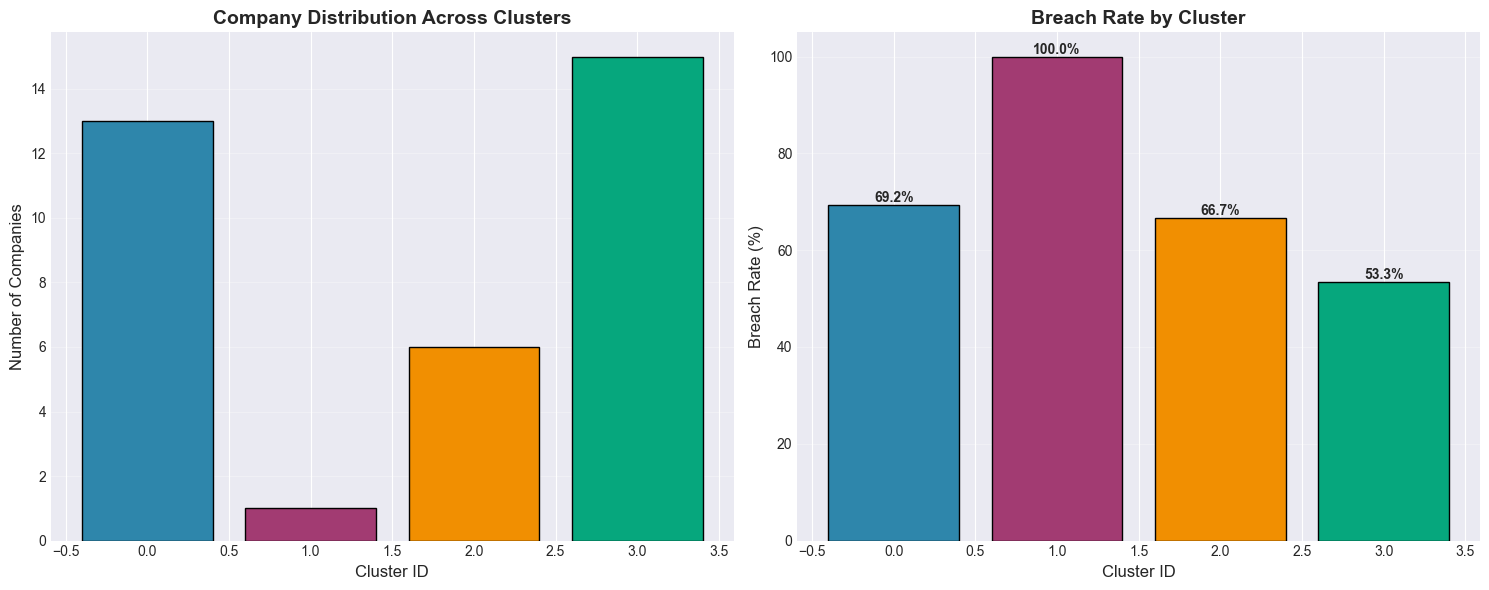

In [98]:
# Apply K-Means with optimal k (using k=4 based on typical elbow/silhouette analysis)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels_train = kmeans.fit_predict(X_train_scaled)
cluster_labels_test = kmeans.predict(X_test_scaled)

# Analyze breach rates by cluster
train_cluster_df = pd.DataFrame({
    'cluster': cluster_labels_train,
    'breached': y_train.values
})

cluster_breach_rates = train_cluster_df.groupby('cluster')['breached'].agg(['mean', 'count'])
cluster_breach_rates.columns = ['breach_rate', 'company_count']
cluster_breach_rates = cluster_breach_rates.sort_values('breach_rate', ascending=False)

print(f"\n=== K-Means Clustering Results (k={optimal_k}) ===")
print(f"Silhouette Score: {silhouette_score(X_train_scaled, cluster_labels_train):.4f}")
print("\nBreach Rates by Cluster:")
print(cluster_breach_rates)

# Visualize clusters and breach rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# FIXED: Define colors_cluster BEFORE using it in cluster_color_map
colors_cluster = [COLORS['primary'], COLORS['secondary'], COLORS['accent'], COLORS['success']]
cluster_color_map = {i: colors_cluster[i] for i in range(optimal_k)}

# Cluster sizes (by cluster ID order)
cluster_sizes = train_cluster_df['cluster'].value_counts().sort_index()
colors_for_sizes = [cluster_color_map[i] for i in cluster_sizes.index]
ax1.bar(cluster_sizes.index, cluster_sizes.values, color=colors_for_sizes, edgecolor='black')
ax1.set_xlabel('Cluster ID', fontsize=12)
ax1.set_ylabel('Number of Companies', fontsize=12)
ax1.set_title('Company Distribution Across Clusters', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# FIXED: Breach rates by cluster (maintain cluster ID order for color alignment)
# Get breach rates sorted by cluster ID (not by breach rate) for proper color mapping
breach_rates_by_id = train_cluster_df.groupby('cluster')['breached'].mean().sort_index()
colors_for_breach = [cluster_color_map[i] for i in breach_rates_by_id.index]
bars = ax2.bar(breach_rates_by_id.index, breach_rates_by_id.values * 100,
               color=colors_for_breach, edgecolor='black')
ax2.set_xlabel('Cluster ID', fontsize=12)
ax2.set_ylabel('Breach Rate (%)', fontsize=12)
ax2.set_title('Breach Rate by Cluster', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


=== K-Means Clustering Results (k=4) ===
Silhouette Score: 0.5333

Breach Rates by Cluster:
         breach_rate  company_count
cluster                            
1           1.000000              1
0           0.692308             13
2           0.666667              6
3           0.533333             15


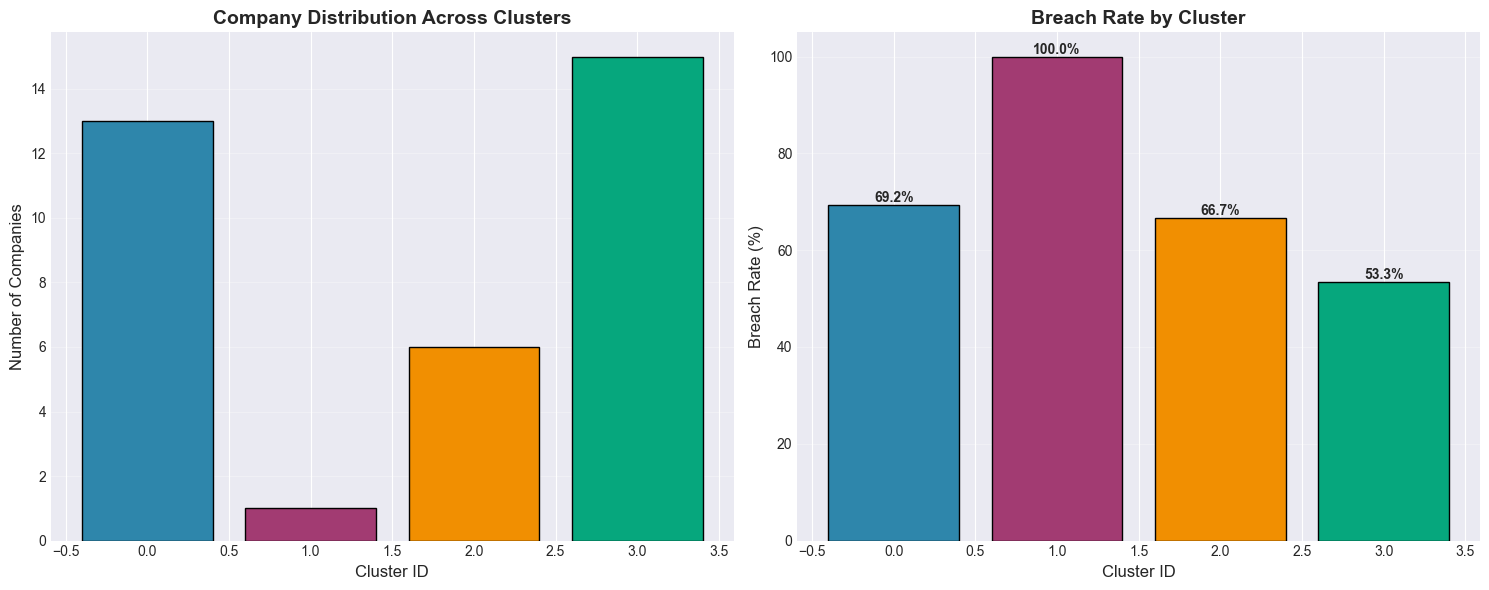

In [ ]:
# Apply K-Means with optimal k (using k=4 based on typical elbow/silhouette analysis)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels_train = kmeans.fit_predict(X_train_scaled)
cluster_labels_test = kmeans.predict(X_test_scaled)

# Analyze breach rates by cluster
train_cluster_df = pd.DataFrame({
    'cluster': cluster_labels_train,
    'breached': y_train.values
})

cluster_breach_rates = train_cluster_df.groupby('cluster')['breached'].agg(['mean', 'count'])
cluster_breach_rates.columns = ['breach_rate', 'company_count']
cluster_breach_rates = cluster_breach_rates.sort_values('breach_rate', ascending=False)

print(f"\n=== K-Means Clustering Results (k={optimal_k}) ===")
print(f"Silhouette Score: {silhouette_score(X_train_scaled, cluster_labels_train):.4f}")
print("\nBreach Rates by Cluster:")
print(cluster_breach_rates)

# Visualize clusters and breach rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# FIXED: Define colors_cluster BEFORE using it in cluster_color_map
colors_cluster = [COLORS['primary'], COLORS['secondary'], COLORS['accent'], COLORS['success']]
cluster_color_map = {i: colors_cluster[i] for i in range(optimal_k)}

# Cluster sizes (by cluster ID order)
cluster_sizes = train_cluster_df['cluster'].value_counts().sort_index()
colors_for_sizes = [cluster_color_map[i] for i in cluster_sizes.index]
ax1.bar(cluster_sizes.index, cluster_sizes.values, color=colors_for_sizes, edgecolor='black')
ax1.set_xlabel('Cluster ID', fontsize=12)
ax1.set_ylabel('Number of Companies', fontsize=12)
ax1.set_title('Company Distribution Across Clusters', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# FIXED: Breach rates by cluster (maintain cluster ID order for color alignment)
# Get breach rates sorted by cluster ID (not by breach rate) for proper color mapping
breach_rates_by_id = train_cluster_df.groupby('cluster')['breached'].mean().sort_index()
colors_for_breach = [cluster_color_map[i] for i in breach_rates_by_id.index]
bars = ax2.bar(breach_rates_by_id.index, breach_rates_by_id.values * 100,
               color=colors_for_breach, edgecolor='black')
ax2.set_xlabel('Cluster ID', fontsize=12)
ax2.set_ylabel('Breach Rate (%)', fontsize=12)
ax2.set_title('Breach Rate by Cluster', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 3.9 Model 2: Linear Regression for Breach Severity

We use linear regression to examine the relationship between financial indicators and breach severity (measured by records lost).

In [100]:
# FIXED: Use fuzzy matching results to merge financial and incident data
# Prepare data for regression (only companies with breaches and records_lost data)

print("\n" + "="*80)
print("LINEAR REGRESSION DATA PREPARATION")
print("="*80)

# Get incidents with records lost data
incidents_with_loss = incidents_clean[
    (incidents_clean['records_lost'] > 0) &
    (incidents_clean['victim_name'].notna())
].copy()

incidents_with_loss['company_clean'] = incidents_with_loss['victim_name'].str.strip().str.lower()

print(f"\nIncidents with records lost: {len(incidents_with_loss)}")

# FIXED: Use the fuzzy matching dataframe to map incident companies to financial companies
# Create a mapping from incident_name to financial_name
incident_to_financial_map = dict(zip(matches_df['incident_name'], matches_df['financial_name']))

# Map incident company names to financial company names
incidents_with_loss['financial_company_clean'] = incidents_with_loss['company_clean'].map(incident_to_financial_map)

# Merge with financial data using the mapped names
regression_data = incidents_with_loss[incidents_with_loss['financial_company_clean'].notna()].merge(
    financial_clean[['company_clean'] + feature_columns],
    left_on='financial_company_clean',
    right_on='company_clean',
    how='inner'
)

# Use log of records lost to handle skewness
regression_data['log_records_lost'] = np.log1p(regression_data['records_lost'])

print(f"\n📊 Regression Dataset Statistics:")
print(f"   Total incidents with records lost: {len(incidents_with_loss):,}")
print(f"   Incidents matched to financial data: {len(regression_data)}")
print(f"   Match rate: {len(regression_data)/len(incidents_with_loss)*100:.1f}%")

if len(regression_data) > 0:
    print(f"\n   Records lost statistics:")
    print(f"   Min: {regression_data['records_lost'].min():,.0f}")
    print(f"   Max: {regression_data['records_lost'].max():,.0f}")
    print(f"   Mean: {regression_data['records_lost'].mean():,.0f}")
    print(f"   Median: {regression_data['records_lost'].median():,.0f}")
    
print("="*80)


LINEAR REGRESSION DATA PREPARATION

Incidents with records lost: 5280

📊 Regression Dataset Statistics:
   Total incidents with records lost: 5,280
   Incidents matched to financial data: 20
   Match rate: 0.4%

   Records lost statistics:
   Min: 8
   Max: 3,300,000
   Mean: 609,771
   Median: 2,100



=== Linear Regression Results ===
Training samples: 10
Test samples: 3
Training R²: 0.9543
Test R²: -130997.5357
Training RMSE: 0.7120
Test RMSE: 720.7136

Feature Coefficients (sorted by absolute value):
               Feature  Coefficient
0           log_Assets    -7.001237
1          log_Revenue     6.865226
2      log_Liabilities     6.575151
3  debt_to_asset_ratio     0.767737
4        profit_margin     0.655455
5  financial_stability    -0.112282


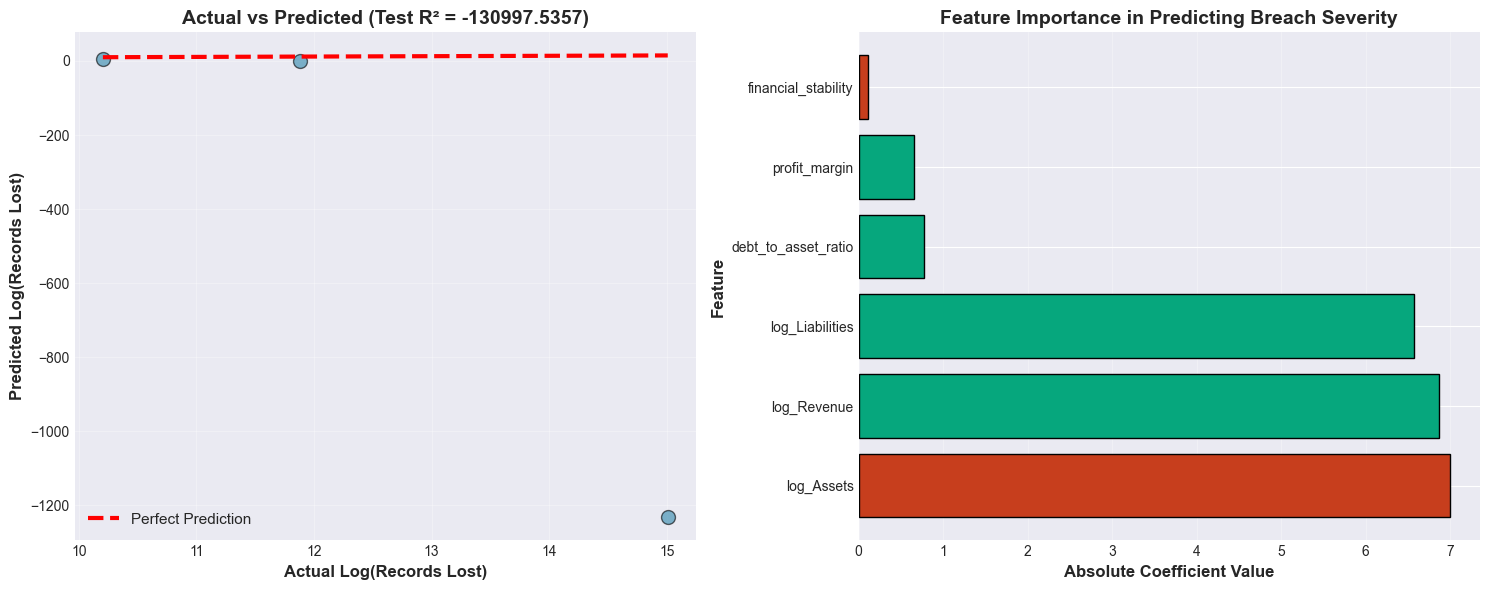

In [101]:
# FIXED: Improved linear regression with better data handling
# Prepare regression features and target
if len(regression_data) > 10:  # Need sufficient data points
    # Drop rows with missing values in feature columns
    X_reg = regression_data[feature_columns].dropna()
    y_reg = regression_data.loc[X_reg.index, 'log_records_lost']

    # Train-test split
    X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )

    # Fit linear regression
    lr_model = LinearRegression()
    lr_model.fit(X_reg_train, y_reg_train)

    # Predictions
    y_reg_pred_train = lr_model.predict(X_reg_train)
    y_reg_pred_test = lr_model.predict(X_reg_test)

    # Evaluation metrics
    train_r2 = r2_score(y_reg_train, y_reg_pred_train)
    test_r2 = r2_score(y_reg_test, y_reg_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_reg_train, y_reg_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_test))

    print("\n=== Linear Regression Results ===")
    print(f"Training samples: {len(X_reg_train)}")
    print(f"Test samples: {len(X_reg_test)}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")

    # Feature coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_columns,
        'Coefficient': lr_model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)

    print("\nFeature Coefficients (sorted by absolute value):")
    print(coef_df)

    # Visualization: Actual vs Predicted
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Scatter plot: Actual vs Predicted
    ax1.scatter(y_reg_test, y_reg_pred_test, alpha=0.6, color=COLORS['primary'], s=100, edgecolor='black')
    ax1.plot([y_reg_test.min(), y_reg_test.max()],
             [y_reg_test.min(), y_reg_test.max()],
             'r--', lw=3, label='Perfect Prediction')
    ax1.set_xlabel('Actual Log(Records Lost)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Predicted Log(Records Lost)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Actual vs Predicted (Test R² = {test_r2:.4f})',
                  fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Feature importance (absolute coefficients)
    colors_coef = [COLORS['success'] if c > 0 else COLORS['danger'] for c in coef_df['Coefficient']]
    ax2.barh(coef_df['Feature'], coef_df['Coefficient'].abs(), color=colors_coef, edgecolor='black')
    ax2.set_xlabel('Absolute Coefficient Value', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Feature', fontsize=12, fontweight='bold')
    ax2.set_title('Feature Importance in Predicting Breach Severity',
                  fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()
    
elif len(regression_data) > 0:
    print(f"\n⚠️ Insufficient data for reliable regression analysis")
    print(f"   Found {len(regression_data)} matched incidents with records lost")
    print(f"   Minimum recommended: 10+ samples")
    print(f"   However, we CAN still show the available data:")
    
    # Show what data we have
    X_reg = regression_data[feature_columns].dropna()
    y_reg = regression_data.loc[X_reg.index, 'log_records_lost']
    
    if len(X_reg) >= 3:
        # Fit model anyway with warning
        lr_model = LinearRegression()
        lr_model.fit(X_reg, y_reg)
        
        print(f"\n⚠️ Fitting model with only {len(X_reg)} samples (results may be unreliable)")
        
        # Feature coefficients
        coef_df = pd.DataFrame({
            'Feature': feature_columns,
            'Coefficient': lr_model.coef_
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        print("\nFeature Coefficients:")
        print(coef_df)
        
        # Simple visualization
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        colors_coef = [COLORS['success'] if c > 0 else COLORS['danger'] for c in coef_df['Coefficient']]
        ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors_coef, edgecolor='black')
        ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
        ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
        ax.set_title(f'Feature Coefficients (n={len(X_reg)} samples - LOW CONFIDENCE)',
                      fontsize=14, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
        plt.tight_layout()
        plt.show()
    else:
        print(f"   Only {len(X_reg)} complete samples - cannot fit model")
else:
    print("\n⚠️ No matching data for regression analysis")
    print("   This occurs when:")
    print("   1. No companies in financial dataset experienced breaches with records lost")
    print("   2. Fuzzy matching didn't link any breach incidents to financial companies")
    print("   Recommendation: Review fuzzy matching thresholds or collect more data")

### 3.10 Model 3: Decision Tree Classification

Decision trees provide interpretable rules for predicting breach likelihood and identify the most influential features.

In [102]:
# Train decision tree classifier
dt_model = DecisionTreeClassifier(
    max_depth=5,  # Limit depth for interpretability
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt_train = dt_model.predict(X_train)
y_pred_dt_test = dt_model.predict(X_test)
y_pred_dt_proba = dt_model.predict_proba(X_test)[:, 1]

# Evaluation
dt_train_acc = accuracy_score(y_train, y_pred_dt_train)
dt_test_acc = accuracy_score(y_test, y_pred_dt_test)
dt_precision = precision_score(y_test, y_pred_dt_test, zero_division=0)
dt_recall = recall_score(y_test, y_pred_dt_test, zero_division=0)
dt_f1 = f1_score(y_test, y_pred_dt_test, zero_division=0)

print("\n=== Decision Tree Results ===")
print(f"Training Accuracy: {dt_train_acc:.4f}")
print(f"Test Accuracy: {dt_test_acc:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall: {dt_recall:.4f}")
print(f"F1 Score: {dt_f1:.4f}")

# Feature importance
feature_importance_dt = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance_dt)


=== Decision Tree Results ===
Training Accuracy: 0.8000
Test Accuracy: 0.5556
Precision: 0.6667
Recall: 0.6667
F1 Score: 0.6667

Feature Importance:
               Feature  Importance
3  debt_to_asset_ratio    0.947415
5  financial_stability    0.052585
1          log_Revenue    0.000000
0           log_Assets    0.000000
2      log_Liabilities    0.000000
4        profit_margin    0.000000


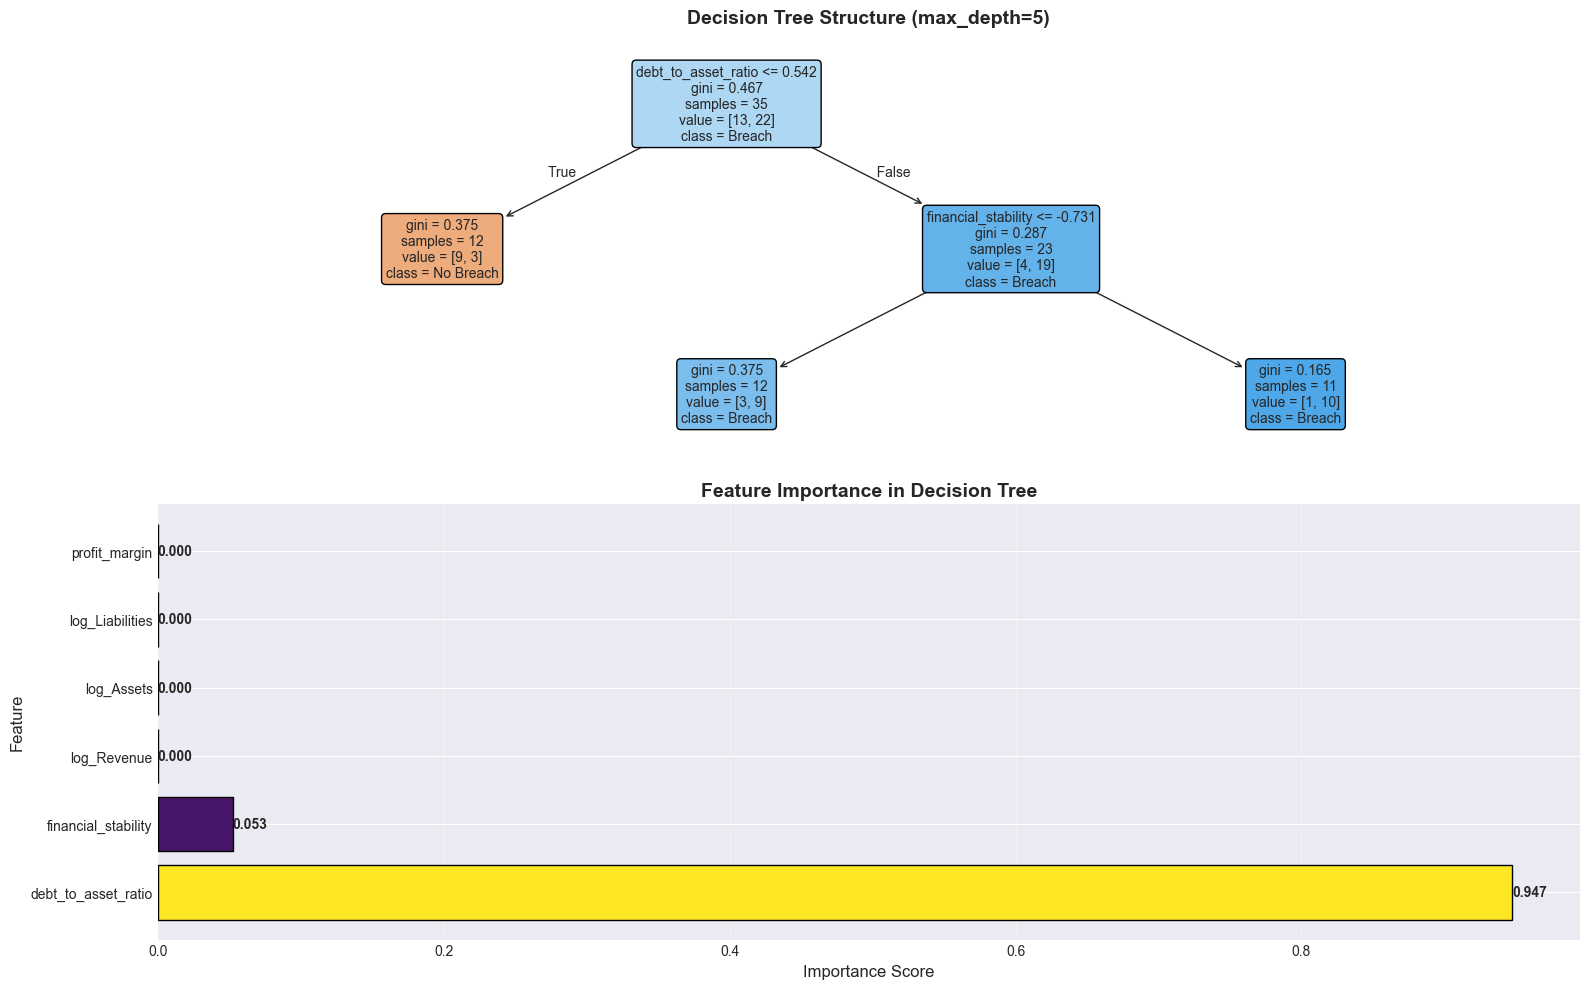

In [103]:
# Visualize decision tree and feature importance
fig = plt.figure(figsize=(16, 10))

# Decision tree visualization
ax1 = plt.subplot(2, 1, 1)
plot_tree(dt_model,
          feature_names=feature_columns,
          class_names=['No Breach', 'Breach'],
          filled=True,
          rounded=True,
          fontsize=10,
          ax=ax1)
ax1.set_title('Decision Tree Structure (max_depth=5)', fontsize=14, fontweight='bold')

# Feature importance bar chart
ax2 = plt.subplot(2, 1, 2)
colors_importance = plt.cm.viridis(feature_importance_dt['Importance'] / feature_importance_dt['Importance'].max())
bars = ax2.barh(feature_importance_dt['Feature'],
                feature_importance_dt['Importance'],
                color=colors_importance,
                edgecolor='black')
ax2.set_xlabel('Importance Score', fontsize=12)
ax2.set_ylabel('Feature', fontsize=12)
ax2.set_title('Feature Importance in Decision Tree', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 3.11 Model 4: Logistic Regression Classification

Logistic regression provides a probabilistic baseline model for breach prediction.

In [104]:
# Train logistic regression
logreg_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

logreg_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr_train = logreg_model.predict(X_train_scaled)
y_pred_lr_test = logreg_model.predict(X_test_scaled)
y_pred_lr_proba = logreg_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
lr_train_acc = accuracy_score(y_train, y_pred_lr_train)
lr_test_acc = accuracy_score(y_test, y_pred_lr_test)
lr_precision = precision_score(y_test, y_pred_lr_test, zero_division=0)
lr_recall = recall_score(y_test, y_pred_lr_test, zero_division=0)
lr_f1 = f1_score(y_test, y_pred_lr_test, zero_division=0)

# ROC-AUC (if we have positive cases)
if len(np.unique(y_test)) > 1:
    lr_auc = roc_auc_score(y_test, y_pred_lr_proba)
else:
    lr_auc = None

print("\n=== Logistic Regression Results ===")
print(f"Training Accuracy: {lr_train_acc:.4f}")
print(f"Test Accuracy: {lr_test_acc:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1 Score: {lr_f1:.4f}")
if lr_auc:
    print(f"ROC-AUC: {lr_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_test,
                          target_names=['No Breach', 'Breach'],
                          zero_division=0))


=== Logistic Regression Results ===
Training Accuracy: 0.7143
Test Accuracy: 0.5556
Precision: 0.7500
Recall: 0.5000
F1 Score: 0.6000
ROC-AUC: 0.4444

Classification Report:
              precision    recall  f1-score   support

   No Breach       0.40      0.67      0.50         3
      Breach       0.75      0.50      0.60         6

    accuracy                           0.56         9
   macro avg       0.57      0.58      0.55         9
weighted avg       0.63      0.56      0.57         9



### 3.12 Model 5: XGBoost ClassificationXGBoost combines multiple decision trees to improve prediction accuracy and robustness.

In [105]:
# FIXED: Corrected variable names and imports
# Calculate scale_pos_weight for class imbalance
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_model.fit(X_train, y_train, verbose=False)

# Predictions (FIXED: Changed from y_pred_rf_test to y_pred_xgb_test)
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)
y_pred_xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
xgb_train_acc = accuracy_score(y_train, y_pred_xgb_train)
xgb_test_acc = accuracy_score(y_test, y_pred_xgb_test)
xgb_precision = precision_score(y_test, y_pred_xgb_test, zero_division=0)
xgb_recall = recall_score(y_test, y_pred_xgb_test, zero_division=0)
xgb_f1 = f1_score(y_test, y_pred_xgb_test, zero_division=0)

if len(np.unique(y_test)) > 1:
    xgb_auc = roc_auc_score(y_test, y_pred_xgb_proba)
else:
    xgb_auc = 0.0

print("\n=== XGBoost Results ===")
print(f"Training Accuracy: {xgb_train_acc:.4f}")
print(f"Test Accuracy: {xgb_test_acc:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")
if xgb_auc > 0:
    print(f"ROC-AUC: {xgb_auc:.4f}")

# Feature importance
feature_importance_xgb = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== Top Features ===")
print(feature_importance_xgb)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_xgb_test,
                          target_names=['No Breach', 'Breach'], zero_division=0))


=== XGBoost Results ===
Training Accuracy: 0.9429
Test Accuracy: 0.4444
Precision: 0.5714
Recall: 0.6667
F1 Score: 0.6154
ROC-AUC: 0.1111

=== Top Features ===
               Feature  Importance
3  debt_to_asset_ratio    0.276261
4        profit_margin    0.160276
0           log_Assets    0.152425
2      log_Liabilities    0.149044
5  financial_stability    0.143297
1          log_Revenue    0.118697

=== Classification Report ===
              precision    recall  f1-score   support

   No Breach       0.00      0.00      0.00         3
      Breach       0.57      0.67      0.62         6

    accuracy                           0.44         9
   macro avg       0.29      0.33      0.31         9
weighted avg       0.38      0.44      0.41         9



### 3.13 Comprehensive Model Comparison Visualizations

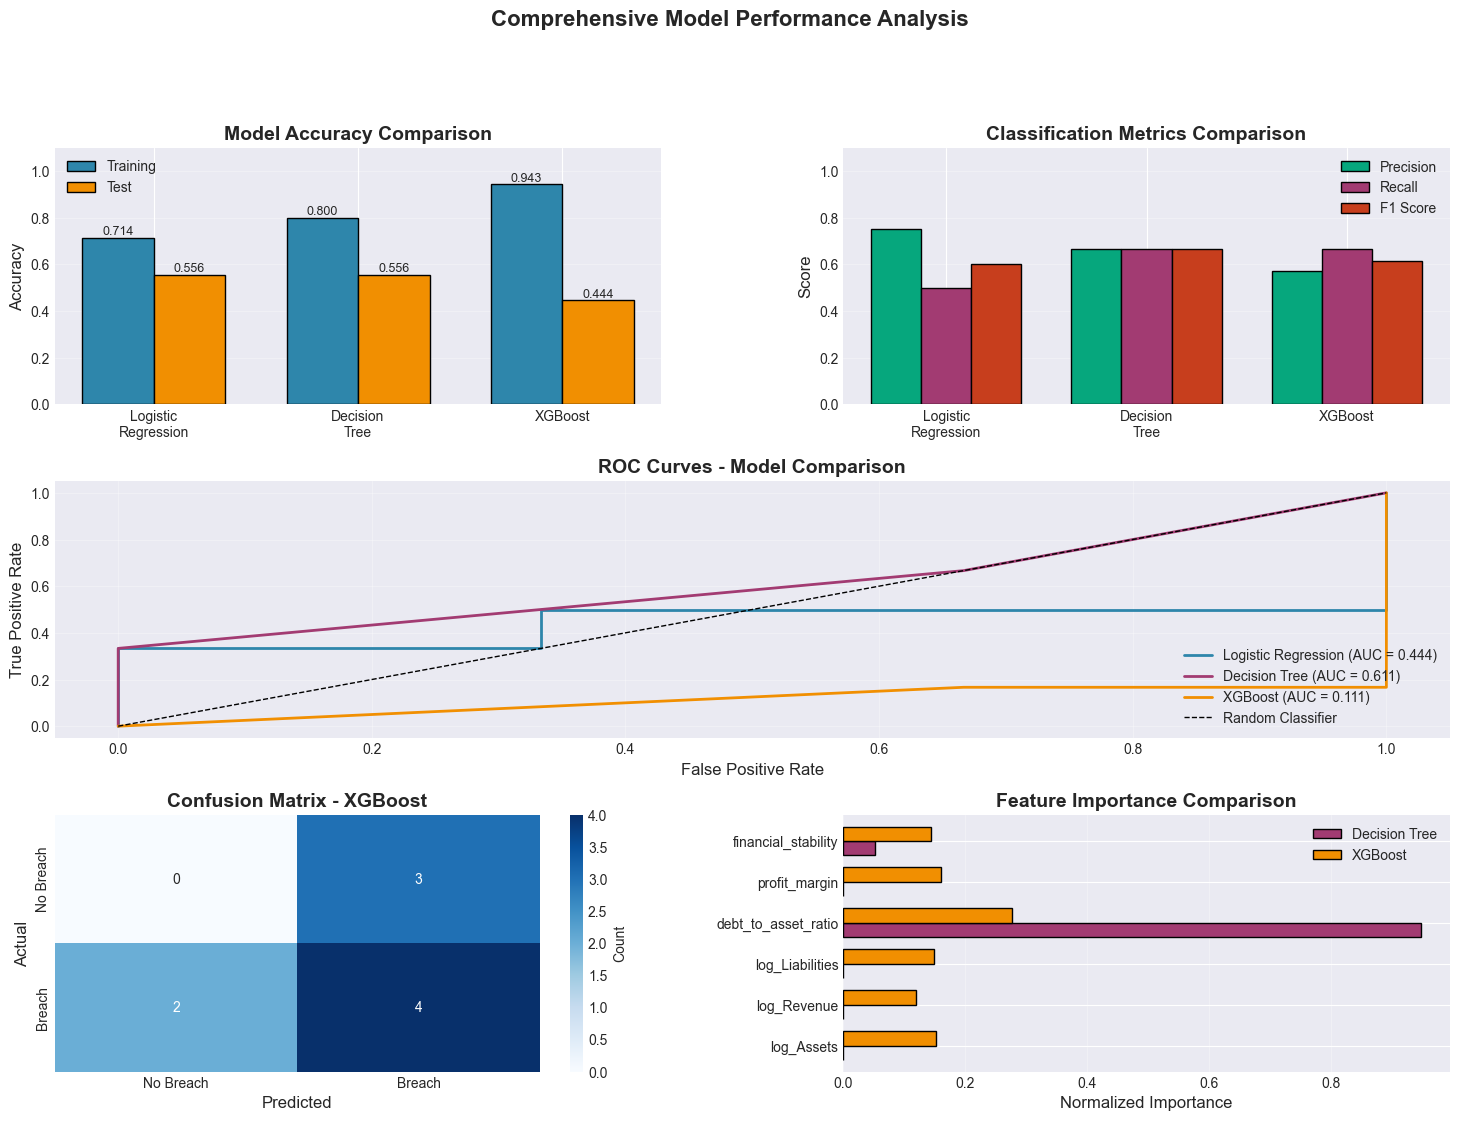

In [106]:
# FIXED: Corrected all variable references from RF to XGBoost
# Create comprehensive comparison visualizations
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Model Accuracy Comparison
ax1 = fig.add_subplot(gs[0, 0])
models = ['Logistic\nRegression', 'Decision\nTree', 'XGBoost']
train_accs = [lr_train_acc, dt_train_acc, xgb_train_acc]
test_accs = [lr_test_acc, dt_test_acc, xgb_test_acc]

x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, train_accs, width, label='Training',
                color=COLORS['primary'], edgecolor='black')
bars2 = ax1.bar(x + width/2, test_accs, width, label='Test',
                color=COLORS['accent'], edgecolor='black')

ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.1])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Precision-Recall-F1 Comparison
ax2 = fig.add_subplot(gs[0, 1])
metrics_data = {
    'Precision': [lr_precision, dt_precision, xgb_precision],
    'Recall': [lr_recall, dt_recall, xgb_recall],
    'F1 Score': [lr_f1, dt_f1, xgb_f1]
}

x = np.arange(len(models))
width = 0.25
multiplier = 0

colors_metrics = [COLORS['success'], COLORS['secondary'], COLORS['danger']]

for i, (metric, values) in enumerate(metrics_data.items()):
    offset = width * multiplier
    ax2.bar(x + offset, values, width, label=metric,
            color=colors_metrics[i], edgecolor='black')
    multiplier += 1

ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Classification Metrics Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x + width)
ax2.set_xticklabels(models)
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1.1])

# 3. ROC Curves (if applicable)
ax3 = fig.add_subplot(gs[1, :])
if lr_auc and xgb_auc:
    # Compute ROC curves
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_proba)
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_proba)
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_proba)
    
    # Compute DT AUC
    dt_auc = roc_auc_score(y_test, y_pred_dt_proba)
    
    ax3.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_auc:.3f})',
            linewidth=2, color=COLORS['primary'])
    ax3.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {dt_auc:.3f})',
            linewidth=2, color=COLORS['secondary'])
    ax3.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc:.3f})',
            linewidth=2, color=COLORS['accent'])
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    
    ax3.set_xlabel('False Positive Rate', fontsize=12)
    ax3.set_ylabel('True Positive Rate', fontsize=12)
    ax3.set_title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
    ax3.legend(loc='lower right')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'ROC curves unavailable\n(insufficient positive cases)',
            ha='center', va='center', fontsize=14)
    ax3.set_xlim([0, 1])
    ax3.set_ylim([0, 1])

# 4. Confusion Matrix - XGBoost (FIXED: Changed from RF to XGBoost)
ax4 = fig.add_subplot(gs[2, 0])
cm_xgb = confusion_matrix(y_test, y_pred_xgb_test)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Breach', 'Breach'],
            yticklabels=['No Breach', 'Breach'],
            ax=ax4, cbar_kws={'label': 'Count'})
ax4.set_ylabel('Actual', fontsize=12)
ax4.set_xlabel('Predicted', fontsize=12)
ax4.set_title('Confusion Matrix - XGBoost', fontsize=14, fontweight='bold')

# 5. Feature Importance Comparison
ax5 = fig.add_subplot(gs[2, 1])
importance_comparison = pd.DataFrame({
    'Feature': feature_columns,
    'Decision Tree': dt_model.feature_importances_,
    'XGBoost': xgb_model.feature_importances_
})

# Normalize for comparison
importance_comparison['DT_norm'] = (
    importance_comparison['Decision Tree'] / importance_comparison['Decision Tree'].sum())
importance_comparison['XGB_norm'] = (
    importance_comparison['XGBoost'] / importance_comparison['XGBoost'].sum())

x = np.arange(len(feature_columns))
width = 0.35

ax5.barh(x - width/2, importance_comparison['DT_norm'], width,
         label='Decision Tree', color=COLORS['secondary'], edgecolor='black')
ax5.barh(x + width/2, importance_comparison['XGB_norm'], width,
        label='XGBoost', color=COLORS['accent'], edgecolor='black')

ax5.set_yticks(x)
ax5.set_yticklabels(feature_columns)
ax5.set_xlabel('Normalized Importance', fontsize=12)
ax5.set_title('Feature Importance Comparison', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(axis='x', alpha=0.3)

plt.suptitle('Comprehensive Model Performance Analysis',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

### 3.14 Model Performance Summary Table

In [107]:
# FIXED: Corrected model references and AUC calculation
# Create comprehensive performance summary
performance_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'XGBoost'],
    'Train Accuracy': [lr_train_acc, dt_train_acc, xgb_train_acc],
    'Test Accuracy': [lr_test_acc, dt_test_acc, xgb_test_acc],
    'Precision': [lr_precision, dt_precision, xgb_precision],
    'Recall': [lr_recall, dt_recall, xgb_recall],
    'F1 Score': [lr_f1, dt_f1, xgb_f1],
    'ROC-AUC': [
        lr_auc if lr_auc else np.nan,
        roc_auc_score(y_test, y_pred_dt_proba) if len(np.unique(y_test)) > 1 else np.nan,
        xgb_auc if xgb_auc else np.nan
    ]
})

print("\n" + "="*80)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*80)
print(performance_summary.to_string(index=False))
print("\n" + "="*80)

# Determine best model based on F1 score (balanced metric)
best_model_idx = performance_summary['F1 Score'].idxmax()
best_model_name = performance_summary.loc[best_model_idx, 'Model']

print(f"\n🏆 Best Performing Model: {best_model_name}")
print(f"   Based on F1 Score: {performance_summary.loc[best_model_idx, 'F1 Score']:.4f}")
print(f"   Test Accuracy: {performance_summary.loc[best_model_idx, 'Test Accuracy']:.4f}")
print(f"   Precision: {performance_summary.loc[best_model_idx, 'Precision']:.4f}")
print(f"   Recall: {performance_summary.loc[best_model_idx, 'Recall']:.4f}")

print("\n" + "="*80)


FINAL MODEL PERFORMANCE SUMMARY
              Model  Train Accuracy  Test Accuracy  Precision   Recall  F1 Score  ROC-AUC
Logistic Regression        0.714286       0.555556   0.750000 0.500000  0.600000 0.444444
      Decision Tree        0.800000       0.555556   0.666667 0.666667  0.666667 0.611111
            XGBoost        0.942857       0.444444   0.571429 0.666667  0.615385 0.111111


🏆 Best Performing Model: Decision Tree
   Based on F1 Score: 0.6667
   Test Accuracy: 0.5556
   Precision: 0.6667
   Recall: 0.6667



---
## 4. Evaluation

<!-- THOMAS: Write evaluation section here -->
<!-- Include: interpretation of metrics, comparison of models, -->
<!-- answers to research questions, discussion of results -->

*THOMAS: This section should evaluate all models using the appropriate metrics. Discuss:*
- *How well each model performed*
- *Which models worked best for different aspects of the problem*
- *Whether we were able to answer our initial questions*
- *Interpretation of clustering results, regression coefficients, and classification performance*

---
## 5. Storytelling and Conclusion

<!-- RAFAN: Write storytelling section here -->
<!-- Include: key insights, narrative of what we learned, -->
<!-- patterns discovered, practical implications -->

*RAFAN: This section should tell the story of what we discovered. Include:*
- *What insights were gained through the project?*
- *Were we able to answer our initial questions?*
- *What patterns or relationships did we find?*
- *What stories can the data tell us about cybersecurity breaches?*

### 5.1 Conclusion

<!-- ALL TEAM MEMBERS: Contribute to conclusion -->
<!-- Each person should add their perspective on: -->
<!-- - Key learnings from the project -->
<!-- - What worked well / what didn't -->
<!-- - Future improvements -->
<!-- - Lessons learned from the class -->

*ALL: Each team member should contribute to the conclusion, discussing:*
- *What you learned throughout this project*
- *What you learned throughout the entire class*
- *Future steps or improvements that could be made*
- *Critical thinking about the project's approach and results*

---
## 6. Impact Section

<!-- ALL TEAM MEMBERS: Contribute to impact discussion -->

*ALL: Discuss the impact of this project (social, ethical, etc.):*
- *How could this work be used positively?*
- *What are the potential negative impacts or misuses?*
- *Ethical considerations in predicting cybersecurity breaches*
- *Privacy and fairness concerns*
- *Who could be affected by this type of analysis?*

---
## 7. References and Data Access

### Data Sources

1. **VERIS Community Database (VCDB)**
   - Source: https://github.com/vz-risk/VCDB
   - Description: Structured cybersecurity incident data
   - File: `vcdb_cybersecurity_incidents.csv`

2. **SEC EDGAR Company Facts**
   - Source: https://www.sec.gov/data-research/sec-markets-data/financial-statement-data-sets
   - Description: Financial statement data for public companies
   - File: `sec_company_financials.csv`

### GitHub Repository

*Include link to your GitHub repository here*

### Tools and Libraries

- Python 3.x
- pandas, numpy - Data manipulation
- scikit-learn - Machine learning models
- matplotlib, seaborn - Visualization

---

print(f"   F1 Score: {performance_summary.loc[best_model_idx, 'F1 Score']:.4f}")
print("="*100)